In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

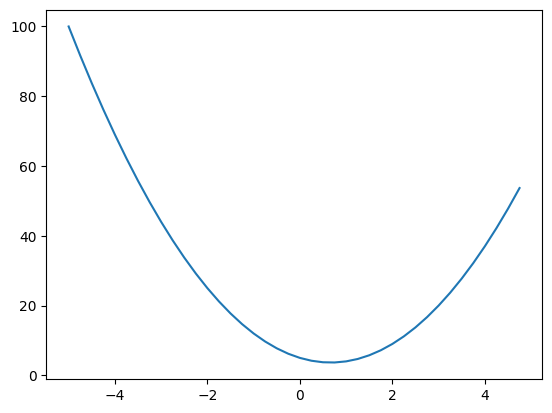

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 3.0
(f(x + h) - f(x))/h

14.000000305713911

In [6]:
# Partial derivative is what happens when we bump a particular value by a particular 
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d = a*b +c 

d1 = a*b + c
a = (a+h)
d2 = a*b + c
print ((d2 - d1) / h)


-3.000000000064062


In [181]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self * other

    def __truedev__(self, other):
        return self * other**-1

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
        return out

    def __rsub__(self, other):
        return -1 * (self - other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), 'pow')
        # Gross
        out.power = other
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self, ), 'exp')

    def backprop(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            if node._op == '+':
                for child in node._prev:
                    child.grad += node.grad

            # Could do self excluding product if there is more.
            elif node._op == '*':
                node._prev[0].grad += node._prev[1].data * node.grad
                node._prev[1].grad += node._prev[0].data * node.grad

            elif node._op == 'tanh':
                node._prev[0].grad += node.grad * (1 - node.data**2)   

            elif node._op == 'exp':
                node._prev[0].grad += node.grad * node.data

            elif node._op == 'pow':
                prev = node._prev[0]
                prev.grad += node.grad * (node.power * prev.data**(node.power - 1))
                print(prev.grad)

            elif node._op == 'sub':
                node_.prev[0].grad = node.grad
                node_.prev[1].grad = -1 * node.grad

In [178]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if (n._op):
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

-16.0


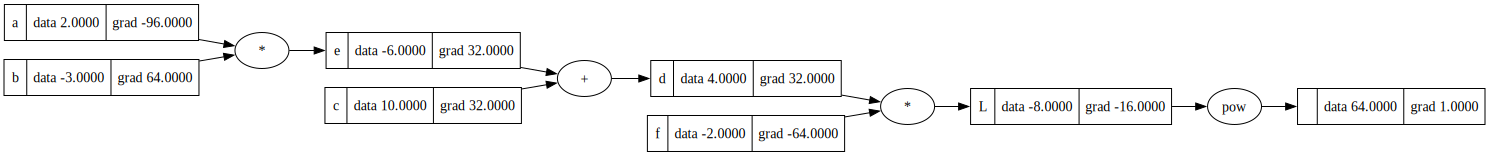

In [137]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L2 = L**2
L2.backprop()
draw_dot(L2)
#print (a**3)

In [138]:
import torch

In [139]:
# .double casts to double instead of float
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())

0.7071066904050358
----
x2 0.5000001283844369


In [195]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w*x + b
        assert len(x) == len(self.w)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]+ nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def eval(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def train_step(self, input_batch, input_batch_target):
        print("hello")
        pred = [self.eval(input_line) for input_line in input_batch]
        loss = sum((prediction - target)**2 for prediction, target in zip(pred, input_batch_target))
        
        for param in self.parameters():
            param.grad = 0
            
        loss.backprop()
        
        for param in self.parameters():
            param.data += -.001 * param.grad

    def train_steps(count, input_batch, input_batch_targets):
        for _ in range(count):
            self.train_step(input_batch, input_batch_targets)


In [196]:
c

Value(data=-0.9242103150832306)


In [198]:
mlp.train_step(xs, ys)

hello
-3.5876813471699656
0.14812910348448294
0.7756873424118704
0.0


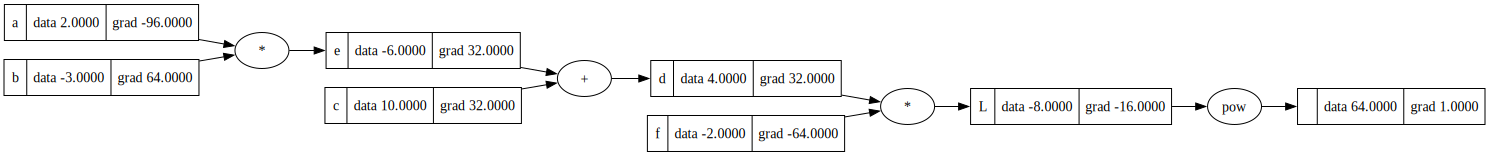

In [186]:
draw_dot(L2)